In [546]:
import argparse
from copy import deepcopy
import logging
import random
from collections import defaultdict
from os.path import join
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score, f1_score, precision_recall_curve
from sklearn.model_selection import train_test_split
import joblib
import imodels
import inspect
import os.path
import imodelsx.cache_save_utils
import sys
import torch

#path_to_repo = os.path.dirname(os.path.dirname(os.path.abspath(__file__)))

#os.chdir(path_to_repo)
#os.chdir('/home/mattyshen/interpretableDistillation')
sys.path.append('..')

import idistill.model
import idistill.data

def distill_model(student, X_train_teacher, y_train_teacher, r, feature_names = None):
    """Distill the teacher model using the student model"""
    
    fit_parameters = inspect.signature(student.fit).parameters.keys()
    if "feature_names" in fit_parameters and feature_names is not None:
        student.fit(X_train_teacher, y_train_teacher, feature_names=feature_names)
    else:
        student.fit(X_train_teacher, y_train_teacher)

    return r, student

def evaluate_student(student, X_train, X_test, y_train, y_test, metric, task, r):
    """Evaluate student performance on each split"""
    
    metrics = {
            "accuracy": accuracy_score,
            "mse": mean_squared_error,
            "r2": r2_score,
            "f1": f1_score,
        
        }
    
    metric_fn = metrics[metric]
    
    for split_name, (X_, y_) in zip(
        ["train", "test"], [(X_train, y_train), (X_test, y_test)]
    ):
        y_pred_ = process_student_eval(student.predict(X_))
        r[f"student_{task}_{split_name}_{metric}"] = metric_fn(y_, y_pred_)

    return r

def evaluate_teacher(y_train_teacher, y_test_teacher, y_train, y_test, metric, task, r):
    metrics = {
            "accuracy": accuracy_score,
            "mse": mean_squared_error,
            "r2": r2_score,
            "f1": f1_score,
        
        }
    
    metric_fn = metrics[metric]
    
    for split_name, (y_teacher_, y_) in zip(
        ["train", "test"], [(y_train_teacher, y_train), (y_test_teacher, y_test)]
    ):
        r[f"teacher_{task}_{split_name}_{metric}"] = metric_fn(y_teacher_, y_)
    
    return r

def predict_teacher(teacher, X, gpu=0):
    ### TODO: handle teacher prediction outputs (X is intended to be concept design matrix, output is intended to be logits)###

    y_pred_torch = teacher.sec_model(torch.tensor(X.values, dtype=torch.float32).to(f'cuda:{gpu}'))
    y_pred = pd.DataFrame(y_pred_torch.detach().cpu().numpy())
        
    return y_pred

def load_teacher_model(teacher_path, gpu=0):
    ### TODO: load in teacher model using teacher_path ###
    
    sys.path.append('/home/mattyshen/ConceptBottleneck')
    try:
        teacher = torch.load(teacher_path, weights_only=False)
    except:
        teacher = torch.load(join(join('home/mattyshen/DistillationEdit/', "models"), teacher_path), weights_only=False)
    teacher.to(f'cuda:{gpu}')
    teacher.eval()
    sys.path.append('/home/mattyshen/DistillationEdit')
    
    return teacher

def generate_tabular_distillation_data(teacher, train_path, test_path, gpu=0):
    ### TODO: generate teacher train and test data using model, train_path, and test_path ###
    
    sys.path.append('/home/mattyshen/ConceptBottleneck/CUB')
    from dataset import load_data
    from config import BASE_DIR
    
    def get_cub_data(teacher, path, data = 'train', override_train = True, batch_size = 32):
        with torch.no_grad():
            if data == 'test':
                test_dir = path
                #print(test_dir)
                # loader = load_data([test_dir], True, False, batch_size, image_dir='images',
                #                    n_class_attr=2, override_train=override_train)
                loader = load_data([test_dir], True, False, batch_size, image_dir='images',
                                   n_class_attr=2)
            else:
                train_dir = path
                val_dir = '/home/mattyshen/ConceptBottleneck/CUB_processed/class_attr_data_10/val.pkl'
                #print(train_dir, val_dir)
                # loader = load_data([train_dir, val_dir], True, False, batch_size, image_dir='images',
                #                    n_class_attr=2, override_train=override_train)
                loader = load_data([train_dir, val_dir], True, False, batch_size, image_dir='images',
                                    n_class_attr=2)
                
            torch.manual_seed(0)
            
            attrs_true = []
            attrs_hat = []
            labels_true = []
            labels_hat = []
            for data_idx, data in enumerate(loader):
                inputs, labels, attr_labels = data
                attr_labels = torch.stack(attr_labels).t()

                inputs_var = torch.autograd.Variable(inputs).to(f'cuda:{gpu}')
                labels_var = torch.autograd.Variable(labels).to(f'cuda:{gpu}')
                outputs = teacher(inputs_var)
                class_outputs = outputs[0]

                attr_outputs = outputs[1:]
                #attr_outputs_sigmoid = attr_outputs

                attrs_hat.append(torch.stack(attr_outputs).squeeze(2).detach().cpu().numpy())
                attrs_true.append(attr_labels.T)
                labels_hat.append(class_outputs.detach().cpu().numpy())
                labels_true.append(labels)

            X_hat = pd.DataFrame(np.concatenate(attrs_hat, axis=1).T, columns = [f'c{i}' for i in range(1, 113)])
            X = pd.DataFrame(np.concatenate(attrs_true, axis = 1).T, columns = [f'c{i}' for i in range(1, 113)])

            y = pd.Series(np.concatenate([l.numpy().reshape(-1, ) for l in labels_true]))
            y_hat = pd.DataFrame(np.concatenate(labels_hat, axis = 0))

            del attrs_hat
            del labels
            del labels_hat
            del loader
            del data
            del inputs
            del outputs
            del class_outputs
            del attr_outputs
            del inputs_var
            del labels_var
            torch.cuda.empty_cache()

            return X_hat, X, y_hat, y

    X_train_teacher, X_train, y_train_teacher, y_train = get_cub_data(teacher, train_path)
    X_test_teacher, X_test, y_test_teacher, y_test = get_cub_data(teacher, test_path, data = 'test')
    
    sys.path.append('/home/mattyshen/DistillationEdit')
    
    return X_train_teacher, X_test_teacher, X_train, X_test, y_train_teacher, y_test_teacher, y_train, y_test
    
def process_distillation_data(X_train_teacher, X_test_teacher, X_train, X_test, y_train_teacher, y_test_teacher):
    ### TODO: process (i.e. binarize, F1-max binarize) data for distillation ###
    
    thresh = 0
    
#     return (X_train_teacher > thresh).astype(int), (X_test_teacher > thresh).astype(int), y_train_teacher, y_test_teacher

    # best_t = np.argmax([np.mean((X_train_teacher.values > t).astype(int) == X_train.values) for t in np.arange(0, 1, 0.01)])
    # thresh = np.arange(0, 1, 0.01)[best_t]
    
    return (X_train_teacher > thresh).astype(int), (X_test_teacher > thresh).astype(int), y_train_teacher, y_test_teacher

def process_student_eval(y_student):
    ### TODO: handle student prediction outputs to match metrics ###
    
    y_pred = np.argmax(y_student, axis = 1)

    return y_pred

def process_teacher_eval(y_teacher):
    ### TODO: process teacher model predictions for evaluations (sometimes we distill a teacher model using a regressor, but want to evaluate class prediction accuracy) ###
    
    y_teacher_eval = y_teacher.idxmax(axis = 1).astype(int).values
    
    return y_teacher_eval

def extract_interactions(student):

    interactions = []

    def traverse_tree(node, current_features, current_depth):

        if node.left is None and node.right is None:
            tree_interactions.append((current_features, np.var(np.abs(node.value))))
            return
        if node.left is not None:
            current_features_l = current_features.copy()
            current_features_l.append('c' + str(node.feature+1))
            traverse_tree(node.left, current_features_l.copy(), current_depth=current_depth+1)
        if node.right is not None:
            current_features_r = current_features.copy()
            current_features_r.append('!c' + str(node.feature+1))
            traverse_tree(node.right, current_features_r.copy(), current_depth=current_depth+1)
            
    try:
        trees = student.trees_
    except:
        trees = student.figs.trees_

    for tree in trees:
        tree_interactions = []
        traverse_tree(tree, [], current_depth=0)
        interactions.append(tree_interactions)
        
    return interactions

def find_closest_keys_vectorized(dictionary, targets):
    keys = np.array(list(dictionary.keys()))
    targets = np.array(targets)
    diffs = np.abs(keys[:, None] - targets)
    closest_key_indices = np.argmin(diffs, axis=0)
    closest_keys = keys[closest_key_indices]

    return closest_keys

def extract_adaptive_intervention(student, X, interactions, number_of_top_paths=0):
    
    figs_dict = {}
    for i, tree in enumerate(interactions):
        tree_dict = {}
        for path, var in tree:
            tree_dict[var] = path
        figs_dict[i] = tree_dict

    test_pred_intervention = student.predict(X, by_tree = True)

    concepts_to_edit = [[] for _ in range(X.shape[0])]
    variances = np.var(np.abs(test_pred_intervention), axis = 1)

    concepts = np.array([find_closest_keys_vectorized(figs_dict[i], variances[:, i]) for i in range(variances.shape[1])])
    orderings_of_interventions = np.argsort(concepts.T, axis = 1)[:, ::-1]
    variances_of_orderings_of_interventions = np.sort(concepts.T, axis = 1)[:, ::-1]
    
    if number_of_top_paths == 0:
        r = range(orderings_of_interventions.shape[1])
    else:
        r = range(number_of_top_paths)

    for t in r:
        for i, l in enumerate(orderings_of_interventions[:, t]):
            new_list = []
            for c in figs_dict[l][variances_of_orderings_of_interventions[i, t]]:
                new_list.append(int(c[1:])-1 if c[0] != '!' else int(c[2:])-1)
            concepts_to_edit[i].append(new_list)
    return concepts_to_edit

def split_list_by_sizes(list1, list2):
    result = []
    for row1, row2 in zip(list1, list2):
        sizes = [len(sublist) for sublist in row1]
        row_result = []
        start = 0
        for size in sizes:
            end = start + size
            row_result.append(list(row2[start:end]))
            start = end
        result.append(row_result)
    return result

In [123]:
attributes = [
    "has_bill_shape::curved_(up_or_down)",
    "has_bill_shape::needle",
    "has_bill_shape::spatulate",
    "has_bill_shape::all-purpose",
    "has_wing_color::blue",
    "has_wing_color::rufous",
    "has_wing_color::grey",
    "has_wing_color::orange",
    "has_wing_color::black",
    "has_wing_color::red",
    "has_upperparts_color::blue",
    "has_upperparts_color::rufous",
    "has_upperparts_color::grey",
    "has_upperparts_color::orange",
    "has_upperparts_color::black",
    "has_upperparts_color::red",
    "has_underparts_color::blue",
    "has_underparts_color::rufous",
    "has_underparts_color::grey",
    "has_underparts_color::orange",
    "has_underparts_color::black",
    "has_underparts_color::red",
    "has_underparts_color::buff",
    "has_breast_pattern::spotted",
    "has_breast_pattern::striped",
    "has_back_color::blue",
    "has_back_color::rufous",
    "has_back_color::grey",
    "has_back_color::orange",
    "has_back_color::black",
    "has_back_color::red",
    "has_tail_shape::rounded_tail",
    "has_upper_tail_color::blue",
    "has_upper_tail_color::rufous",
    "has_upper_tail_color::orange",
    "has_upper_tail_color::black",
    "has_upper_tail_color::red",
    "has_head_pattern::unique_pattern",
    "has_head_pattern::eyering",
    "has_breast_color::blue",
    "has_breast_color::rufous",
    "has_breast_color::grey",
    "has_breast_color::orange",
    "has_breast_color::black",
    "has_breast_color::red",
    "has_throat_color::rufous",
    "has_throat_color::grey",
    "has_throat_color::orange",
    "has_throat_color::black",
    "has_throat_color::red",
    "has_eye_color::orange",
    "has_eye_color::buff",
    "has_bill_length::longer_than_head",
    "has_bill_length::shorter_than_head",
    "has_forehead_color::blue",
    "has_forehead_color::rufous",
    "has_forehead_color::grey",
    "has_forehead_color::orange",
    "has_forehead_color::black",
    "has_under_tail_color::blue",
    "has_under_tail_color::rufous",
    "has_under_tail_color::orange",
    "has_under_tail_color::black",
    "has_under_tail_color::red",
    "has_nape_color::blue",
    "has_nape_color::rufous",
    "has_nape_color::grey",
    "has_nape_color::orange",
    "has_nape_color::black",
    "has_nape_color::red",
    "has_belly_color::blue",
    "has_belly_color::rufous",
    "has_belly_color::grey",
    "has_belly_color::orange",
    "has_belly_color::black",
    "has_belly_color::red",
    "has_belly_color::buff",
    "has_wing_shape::rounded-wings",
    "has_size::large_(16_-_32_in)",
    "has_size::very_large_(32_-_72_in)",
    "has_size::medium_(9_-_16_in)",
    "has_shape::long-legged-like",
    "has_shape::swallow-like",
    "has_shape::perching-like",
    "has_back_pattern::spotted",
    "has_back_pattern::striped",
    "has_back_pattern::multi-colored",
    "has_tail_pattern::spotted",
    "has_tail_pattern::striped",
    "has_tail_pattern::multi-colored",
    "has_primary_color::blue",
    "has_primary_color::rufous",
    "has_primary_color::grey",
    "has_primary_color::orange",
    "has_primary_color::black",
    "has_primary_color::red",
    "has_leg_color::rufous",
    "has_leg_color::orange",
    "has_leg_color::red",
    "has_bill_color::rufous",
    "has_bill_color::orange",
    "has_bill_color::red",
    "has_bill_color::buff",
    "has_crown_color::blue",
    "has_crown_color::rufous",
    "has_crown_color::grey",
    "has_crown_color::orange",
    "has_crown_color::black",
    "has_crown_color::buff",
    "has_wing_pattern::solid",
    "has_wing_pattern::spotted",
    "has_wing_pattern::striped",
]


In [114]:
class ARGS:
    def __init__(self, a_dict):
        for k in a_dict.keys():
            exec(f'self.{k} = a_dict["{k}"]')
        

In [352]:
args = {}
#args['save_dir'] = join(path_to_repo, "results")  # The default value
args['teacher_path'] = '/home/mattyshen/DistillationEdit/models/cub/outputs/best_Joint0.01_Linear_model_1.pth'  # The default value
args['train_path'] = '/home/mattyshen/ConceptBottleneck/CUB_processed/class_attr_data_10/train.pkl'  # The default value
args['test_path'] = '/home/mattyshen/ConceptBottleneck/CUB_processed/class_attr_data_10/test.pkl'  # The default value
args['task_type'] = "regression"  # The default value
args['student_name'] = "FIGSRegressor"  # The default value
args['max_rules'] = 200  # The default value
args['max_trees'] = 30  # The default value
args['max_depth'] = 3  # The default value
args['min_impurity_decrease'] = 0  # The default value
args['metric'] = "accuracy"  # The default value
args['num_interactions_intervention'] = 3  # The default value
args['n_trees_list'] = [30,40]
args['n_rules_list'] = [125, 150, 200]
args['n_depth_list'] = [4]
args['min_impurity_decrease_list'] = [0]
args['gpu'] = 0

args = ARGS(args)

In [326]:
r = defaultdict(list)

In [327]:
teacher = load_teacher_model(args.teacher_path, args.gpu)
    
X_train_t, X_test_t, X_train, X_test, y_train_t, y_test_t, y_train, y_test = generate_tabular_distillation_data(teacher, args.train_path, args.test_path, args.gpu)

X_train_d, X_test_d, y_train_d, y_test_d = process_distillation_data(X_train_t, X_test_t, X_train, X_test, y_train_t, y_test_t)

y_train_t_eval = process_teacher_eval(y_train_t)
y_test_t_eval = process_teacher_eval(y_test_t)

/home/mattyshen/anaconda3/lib/python3.9/site-packages/torch/serialization.py:1189: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/mattyshen/anaconda3/lib/python3.9/site-packages/torch/serialization.py:1189: SourceChangeWarning: source code of class 'torch.nn.modules.batchnorm.BatchNorm2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/mattyshen/anaconda3/lib/python3.9/site-packages/torch/serialization.py:1189: SourceChangeWarning: source code of class 'torch.nn.modules.container.ModuleList' has changed. you can retrieve the original source c

In [328]:
X_train_d, X_test_d, y_train_d, y_test_d = process_distillation_data(X_train_t, X_test_t, X_train, X_test, y_train_t, y_test_t)

y_train_t_eval = process_teacher_eval(y_train_t)
y_test_t_eval = process_teacher_eval(y_test_t)

In [329]:
train_q5 = np.quantile(X_train_t, 0.05, axis = 0)
train_q95 = np.quantile(X_train_t, 0.95, axis = 0)

In [353]:
figs_student = idistill.model.get_model(args.task_type, args.student_name, args)

In [354]:
r, figs_student = distill_model(figs_student, X_train_d, y_train_d, r)

In [355]:
r = evaluate_student(figs_student, X_train_d, X_test_d, y_train_t_eval, y_test_t_eval, args.metric, "distillation", r)
r = evaluate_student(figs_student, X_train_d, X_test_d, y_train, y_test, args.metric, "prediction", r)

r = evaluate_teacher(y_train_t_eval, y_test_t_eval, y_train, y_test, args.metric, "prediction", r)

In [356]:
r

defaultdict(list,
            {'student_distillation_train_accuracy': 0.9410093582887701,
             'student_distillation_test_accuracy': 0.8439765274421815,
             'student_prediction_train_accuracy': 0.9339906417112299,
             'student_prediction_test_accuracy': 0.7488781498101484,
             'teacher_prediction_train_accuracy': 0.9705882352941176,
             'teacher_prediction_test_accuracy': 0.7984121505005177})

In [1525]:
import pickle
from PIL import Image
import torchvision.transforms as transforms

def visualizer(data, idx, teacher, student):
    img_data = data[idx]
    img_path = img_data['img_path']
    
    try:
        idx = img_path.split('/').index('CUB_200_2011')
        img_path = '/'.join(img_path.split('/')[idx:])
        img = Image.open(img_path).convert('RGB')
    except:
        img_path_split = img_path.split('/')
        split = 'test'
        try:
            img_path = '/'.join(img_path_split[:2] + [split] + img_path_split[2:])
            try:
                img = Image.open(img_path).convert('RGB')
            except:
                img = Image.open('/home/mattyshen/ConceptBottleneck/'+img_path).convert('RGB')
        except:
            img_path = '/'.join(img_path_split[:2] + img_path_split[2:])
            try:
                img = Image.open(img_path).convert('RGB')
            except:
                img = Image.open('/home/mattyshen/ConceptBottleneck/'+img_path).convert('RGB')
    transform = transforms.Compose([
            #transforms.Resize((resized_resol, resized_resol)),
            transforms.CenterCrop(299),
            transforms.ToTensor(), #implicitly divides by 255
            transforms.Normalize(mean = [0.5, 0.5, 0.5], std = [2, 2, 2])
            #transforms.Normalize(mean = [ 0.485, 0.456, 0.406 ], std = [ 0.229, 0.224, 0.225 ]),
            ])
    attr_label = img_data['attribute_label']
    class_label = img_data['class_label']
    
    pred = teacher(torch.autograd.Variable(transform(img)).unsqueeze(0).to(f'cuda:{args.gpu}'))
    class_pred = pred[0].detach().cpu().numpy()
    attr_preds = torch.tensor(pred[1:]).detach().cpu().numpy()
    
    
    
    
    return img, class_label, class_pred, np.array(attr_label), (attr_preds > 0).astype(int), attr_preds
    
data = []

data.extend(pickle.load(open(args.test_path, 'rb')))

img, class_label, class_pred, attr_label, attr_preds, attr_preds_raw = visualizer(data, 96, teacher, 0)

In [1437]:
y_test_t.idxmax(axis=1)

0        71
1         0
2         0
3         0
4         0
       ... 
5789    199
5790    199
5791    199
5792    199
5793    199
Length: 5794, dtype: int64

In [1438]:
[i for i, val in enumerate(y_test_t_eval != y_test) if val == 1][900:915]

[4089,
 4090,
 4091,
 4093,
 4095,
 4096,
 4099,
 4102,
 4103,
 4104,
 4105,
 4106,
 4117,
 4118,
 4119]

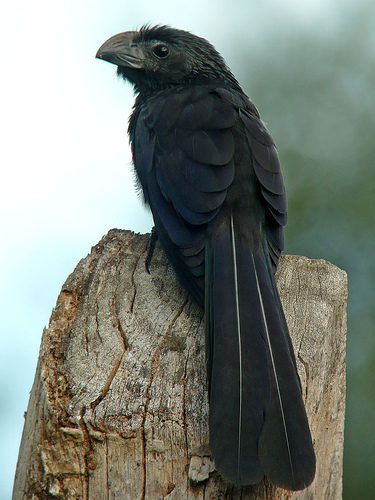

In [1526]:
img

In [1463]:
figs_interactions = extract_interactions(figs_student)

cti_adap_test = extract_adaptive_intervention(figs_student, X_test_d, figs_interactions, 2)

In [1464]:
attr_preds.shape

(112,)

In [1465]:
test_l_edit = np.einsum('nc, yc -> nyc', X_test_t.values, teacher.sec_model.linear.weight.cpu().detach().numpy())

cti_l_test_arr = np.argsort(np.var(np.abs(test_l_edit), axis = 1), axis = 1)[:, ::-1]
cti_l_test = [row for row in cti_l_test_arr]
cti_l_test = split_list_by_sizes(cti_adap_test, cti_l_test)

In [1479]:
cti_l = [l[0] + l[1] for l in cti_l_test]

In [1480]:
cti_a = [l[0] + l[1] for l in cti_adap_test]

In [1481]:
X_test_t_a_edit = X_test_t.copy()
X_test_t_l_edit = X_test_t.copy()

for i in range(len(cti_l_test)):
    X_test_t_a_edit.iloc[i, cti_a[i]] = train_q5[cti_a[i]]*(X_test.iloc[i, cti_a[i]] == 0) + train_q95[cti_a[i]]*(X_test.iloc[i, cti_a[i]])
    X_test_t_l_edit.iloc[i, cti_l[i]] = train_q5[cti_l[i]]*(X_test.iloc[i, cti_l[i]] == 0) + train_q95[cti_l[i]]*(X_test.iloc[i, cti_l[i]])

In [1483]:
new_l_test = predict_teacher(teacher, X_test_t_l_edit)
new_a_test = predict_teacher(teacher, X_test_t_a_edit)


In [1489]:
adap_good = (new_l_test.idxmax(axis = 1).to_numpy() != y_test) & (new_a_test.idxmax(axis = 1).to_numpy() == y_test)

In [1493]:
adap_good = [i for i, val in enumerate(adap_good) if val == 1]

In [1498]:
adap_good[:10]

[5, 92, 96, 100, 113, 129, 138, 193, 194, 198]

In [1500]:
attr_preds

array([0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0])

In [1603]:
figs_interactions = extract_interactions(figs_student)

cti_adap_test = extract_adaptive_intervention(figs_student, attr_preds.reshape(1, -1), figs_interactions, 2)

In [1604]:
test_l_edit = np.einsum('nc, yc -> nyc', attr_preds_raw.reshape(1, -1), teacher.sec_model.linear.weight.cpu().detach().numpy())

cti_l_test_arr = np.argsort(np.var(np.abs(test_l_edit), axis = 1), axis = 1)[:, ::-1]
cti_l_test = [row for row in cti_l_test_arr]
cti_l_test = split_list_by_sizes(cti_adap_test, cti_l_test)

In [1605]:
print(f'CBM predicted class: {np.argmax(class_pred)+1}, correct class is: {class_label+1}')

CBM predicted class: 25, correct class is: 4


In [1606]:
cti_l_test

[[[53, 70, 81], [23, 101]]]

In [1607]:
cti = sum(cti_adap_test[0], [])
cti_l =sum(cti_l_test[0], [])

In [1608]:
print(f'FIGS suggests I firstly intervene on the following concepts: {np.array(attributes)[sum(cti_adap_test[0], [])]}')

FIGS suggests I firstly intervene on the following concepts: ['has_wing_color::blue' 'has_shape::swallow-like'
 'has_size::very_large_(32_-_72_in)' 'has_primary_color::rufous'
 'has_back_color::orange']


In [1609]:
print(f'Linear suggests I firstly intervene on the following concepts: {np.array(attributes)[cti_l]}')

Linear suggests I firstly intervene on the following concepts: ['has_bill_length::shorter_than_head' 'has_belly_color::blue'
 'has_shape::long-legged-like' 'has_breast_pattern::spotted'
 'has_bill_color::red']


In [1610]:
attr_preds_raw[cti]

array([-4.5965548 , -3.5837233 ,  0.21211135, -5.5468364 ,  5.0321856 ],
      dtype=float32)

In [1611]:
print(f'CBM predicted {attr_preds[cti]} for the (FIGS suggested) concepts {np.array(attributes)[cti]}')

CBM predicted [0 0 1 0 1] for the (FIGS suggested) concepts ['has_wing_color::blue' 'has_shape::swallow-like'
 'has_size::very_large_(32_-_72_in)' 'has_primary_color::rufous'
 'has_back_color::orange']


In [1612]:
print(f'the true values are {attr_label[cti]} for the (FIGS suggested) concepts {np.array(attributes)[cti]}')

the true values are [0 0 0 0 1] for the (FIGS suggested) concepts ['has_wing_color::blue' 'has_shape::swallow-like'
 'has_size::very_large_(32_-_72_in)' 'has_primary_color::rufous'
 'has_back_color::orange']


In [1613]:
print(f'CBM predicted {attr_preds[cti_l]} for the (Linear suggested) concepts {np.array(attributes)[cti_l]}')
print(f'the true values are {attr_label[cti_l]} for the (Linear suggested) concepts {np.array(attributes)[cti_l]}')

CBM predicted [0 0 0 0 0] for the (Linear suggested) concepts ['has_bill_length::shorter_than_head' 'has_belly_color::blue'
 'has_shape::long-legged-like' 'has_breast_pattern::spotted'
 'has_bill_color::red']
the true values are [0 0 0 0 0] for the (Linear suggested) concepts ['has_bill_length::shorter_than_head' 'has_belly_color::blue'
 'has_shape::long-legged-like' 'has_breast_pattern::spotted'
 'has_bill_color::red']


In [1614]:
attr_preds_raw_figs = attr_preds_raw.copy()
attr_preds_raw_lin = attr_preds_raw.copy()

In [1615]:
np.mean(attr_preds_raw_figs == attr_preds_raw_lin)

1.0

In [1616]:
attr_preds_new = attr_preds.copy()
attr_preds_new[cti] = attr_label[cti]

In [1661]:
figs_pred = figs_student.predict(attr_preds.reshape(1, -1),  by_tree = True)
figs_new_pred = figs_student.predict(attr_preds_new.reshape(1, -1),  by_tree = True)


In [1662]:
np.argmax(np.sum(figs_pred, axis = 2), axis=1), np.argmax(np.sum(figs_new_pred, axis = 2), axis=1)

(array([24]), array([3]))

In [1626]:
np.mean(figs_pred[:, :,1:] == figs_new_pred[:, :,1:])

1.0

In [1643]:
t = []
for i in range(30):
    t.append(np.mean((figs_pred[:, :,:] == figs_new_pred[:, :,:]).squeeze(0)[:, i]))

In [1666]:
np.argmax(attr_preds !=attr_preds_new)

79

In [1667]:
attr_preds_new[79]

0

In [1645]:

figs_dict = {}
for i, tree in enumerate(figs_interactions):
    tree_dict = {}
    for path, var in tree:
        tree_dict[var] = path
    figs_dict[i] = tree_dict

In [1648]:
figs_dict[0]

{2.059555938814191: ['c5', 'c83', 'c80'],
 3.3305485280546656: ['c5', 'c83', '!c80'],
 1.7365235898169784: ['c5', '!c83', 'c13'],
 4.262624220969785: ['c5', '!c83', '!c13'],
 2.793659619500762: ['!c5', 'c32', 'c55'],
 5.372903789071176: ['!c5', 'c32', '!c55'],
 4.6553001617223595: ['!c5', '!c32', 'c104'],
 5.7043529580263455: ['!c5', '!c32', '!c104']}

In [1668]:
figs_student.trees_[0]

X_4 <= 0.500 (Tree #0 root)

In [1653]:
attr_preds[[4, 82, 79, 12, 31, 54, 103]]

array([0, 0, 1, 0, 0, 0, 0])

In [1649]:
attr_preds_new[[4, 82, 79, 12, 31, 54, 103]]

array([0, 0, 0, 0, 0, 0, 0])

In [1621]:
figs_dict[0]

{2.059555938814191: ['c5', 'c83', 'c80'],
 3.3305485280546656: ['c5', 'c83', '!c80'],
 1.7365235898169784: ['c5', '!c83', 'c13'],
 4.262624220969785: ['c5', '!c83', '!c13'],
 2.793659619500762: ['!c5', 'c32', 'c55'],
 5.372903789071176: ['!c5', 'c32', '!c55'],
 4.6553001617223595: ['!c5', '!c32', 'c104'],
 5.7043529580263455: ['!c5', '!c32', '!c104']}

In [1678]:
#old pred
figs_student.trees_[0].left.left.right.value[[24, 3]]

array([ 3.87245916, -1.43478454])

In [1679]:
#new pred
figs_student.trees_[0].left.left.left.value[[24, 3]]

array([ 1.02169042, -0.63318187])

In [1680]:
figs_student.trees_[0].left.left.left.value[[24, 3]] - figs_student.trees_[0].left.left.right.value[[24, 3]]

array([-2.85076874,  0.80160266])

In [1593]:
attr_preds_raw_new = attr_preds_raw.copy()
attr_preds_raw_new[cti_l] = attr_label[cti_l]

In [1598]:
lin_pred_diff = predict_teacher(teacher, pd.DataFrame(attr_preds_raw_new).T) - predict_teacher(teacher, pd.DataFrame(attr_preds_raw).T)

In [1699]:
lin_pred_diff.values[0][[24, 3]]

array([ 0.3371992 , -0.07949638], dtype=float32)

In [1698]:
predict_teacher(teacher, pd.DataFrame(attr_preds_raw).T).idxmax(axis = 1), predict_teacher(teacher, pd.DataFrame(attr_preds_raw_new).T).idxmax(axis = 1)

(0    24
 dtype: int64,
 0    24
 dtype: int64)

In [1551]:
figs_new_pred

array([[[ 3.35303671e-01, -3.29593247e+00,  1.05558986e+00, ...,
         -2.66128942e-02,  1.12699489e-01,  9.54886592e-02],
        [-3.35483533e-01,  2.48748905e-03, -1.32330267e+00, ...,
         -1.14853363e-01,  9.28504617e-03,  1.78227556e-01],
        [ 1.76931225e+00, -1.84347148e+00,  6.43894407e-01, ...,
         -5.30881237e-02,  3.88540526e-01, -3.28377520e-01],
        ...,
        [ 7.03241867e-01, -1.92007084e+00, -1.26673801e-01, ...,
          2.67945873e-02,  1.85555144e-01, -6.83904148e-02],
        [-4.51601626e+00, -1.06182727e+00,  1.57266252e+00, ...,
          5.15945802e-02, -1.08385224e-01,  5.12597908e-01],
        [-2.19215693e+00, -4.80373767e-01,  2.27498026e-01, ...,
         -3.36607134e-02, -2.66361608e-01, -8.84650009e-02]]])

In [1540]:
attr_preds_raw_figs[cti] = train_q5[cti]*(attr_label[cti] == 0) + train_q95[cti]*(attr_label[cti])

In [1541]:
attr_preds_raw_lin[cti_l] = train_q5[cti_l]*(attr_label[cti_l] == 0) + train_q95[cti_l]*(attr_label[cti_l])

In [1542]:
np.mean(attr_preds_raw_figs == attr_preds_raw_lin)

0.9107142857142857

In [1545]:
print(f'CBM now, with FIGS suggestion, predicts: {predict_teacher(teacher, pd.DataFrame(attr_preds_raw_figs).T, gpu=args.gpu).idxmax(axis = 1).values+1}')

CBM now, with FIGS suggestion, predicts: [4]


In [1546]:
print(f'CBM now, with Linear suggestion, predicts: {predict_teacher(teacher, pd.DataFrame(attr_preds_raw_lin).T, gpu=args.gpu).idxmax(axis = 1).values+1}')

CBM now, with Linear suggestion, predicts: [188]


In [1214]:
np.mean(attr_preds_raw_figs == attr_preds_raw_lin)

0.9107142857142857

In [184]:
attr_pred_indexes = [i for i, val in enumerate(attr_preds) if val == 1]
attr_indexes = [i for i, val in enumerate(attr_label) if val == 1]

In [185]:
print('CBM correctly sees the following concepts: ')

set(np.array(attributes)[attr_indexes]).intersection(set(np.array(attributes)[attr_pred_indexes]))

CBM correctly sees the following concepts: 


{'has_belly_color::buff',
 'has_belly_color::grey',
 'has_bill_length::longer_than_head',
 'has_bill_shape::spatulate',
 'has_breast_color::grey',
 'has_crown_color::grey',
 'has_eye_color::orange',
 'has_head_pattern::eyering',
 'has_nape_color::grey',
 'has_primary_color::grey',
 'has_shape::swallow-like',
 'has_size::large_(16_-_32_in)',
 'has_tail_pattern::multi-colored',
 'has_throat_color::grey',
 'has_under_tail_color::orange',
 'has_underparts_color::buff',
 'has_underparts_color::grey',
 'has_wing_pattern::striped'}

In [160]:
print('CBM misses the following concepts that are present: ')

set(np.array(attributes)[attr_indexes]) - set(np.array(attributes)[attr_pred_indexes])

CBM misses the following concepts that are present: 


{'has_belly_color::grey',
 'has_bill_color::rufous',
 'has_bill_shape::spatulate',
 'has_breast_color::grey',
 'has_crown_color::rufous',
 'has_forehead_color::rufous',
 'has_leg_color::red',
 'has_nape_color::rufous',
 'has_primary_color::grey',
 'has_underparts_color::grey'}

In [161]:
print('CBM sees the following concepts that are not present: ')

set(np.array(attributes)[attr_pred_indexes]) - set(np.array(attributes)[attr_indexes])

CBM sees the following concepts that are not present: 


{'has_belly_color::buff',
 'has_bill_color::orange',
 'has_bill_shape::all-purpose',
 'has_wing_color::orange'}

In [106]:
r = evaluate_student(figs_student, X_train_d, X_test_d, y_train_t_eval, y_test_t_eval, args.metric, "distillation", r)
r = evaluate_student(figs_student, X_train_d, X_test_d, y_train, y_test, args.metric, "prediction", r)

r = evaluate_teacher(y_train_t_eval, y_test_t_eval, y_train, y_test, args.metric, "prediction", r)

In [107]:
r

defaultdict(list,
            {'student_distillation_train_accuracy': 0.9495320855614974,
             'student_distillation_test_accuracy': 0.6926130479806697,
             'student_prediction_train_accuracy': 0.9428475935828877,
             'student_prediction_test_accuracy': 0.47911632723507075,
             'teacher_prediction_train_accuracy': 0.97576871657754,
             'teacher_prediction_test_accuracy': 0.5177770107007249})

In [ ]:
figs_interactions = extract_interactions(figs_student)

In [ ]:
figs_dict = {}
for i, tree in enumerate(figs_interactions):
    tree_dict = {}
    for path, var in tree:
        tree_dict[var] = path
    figs_dict[i] = tree_dict

In [ ]:
def find_closest_keys_vectorized(dictionary, targets):
    keys = np.array(list(dictionary.keys()))
    targets = np.array(targets)
    diffs = np.abs(keys[:, None] - targets) 
    closest_key_indices = np.argmin(diffs, axis=0)
    closest_keys = keys[closest_key_indices]

    return closest_keys

In [ ]:
def extract_adap_interv_plot(student, X, interactions, number_of_top_paths=0):

    
    test_pred_intervention = student.predict(X, by_tree = True)

    concepts_to_edit = [[] for _ in range(X.shape[0])]
    variances = np.var(np.abs(test_pred_intervention), axis = 1)

    concepts = np.array([find_closest_keys_vectorized(figs_dict[i], variances[:, i]) for i in range(variances.shape[1])])
    orderings_of_interventions = np.argsort(concepts.T, axis = 1)[:, ::-1]
    variances_of_orderings_of_interventions = np.sort(concepts.T, axis = 1)[:, ::-1]
    
    if number_of_top_paths == 0:
        r = range(orderings_of_interventions.shape[1])
    else:
        r = range(number_of_top_paths)

    for t in r:
        for i, l in enumerate(orderings_of_interventions[:, t]):
            new_list = []
            for c in figs_dict[l][variances_of_orderings_of_interventions[i, t]]:
                new_list.append(int(c[1:])-1 if c[0] != '!' else int(c[2:])-1)
            concepts_to_edit[i].append(new_list)
    return concepts_to_edit

In [ ]:
figs_interactions = extract_interactions(figs_student)

train_q5 = np.quantile(X_train_t, 0.05, axis = 0)
train_q95 = np.quantile(X_train_t, 0.95, axis = 0)

In [ ]:
def split_list_by_sizes(list1, list2):
    result = []
    for row1, row2 in zip(list1, list2):
        sizes = [len(sublist) for sublist in row1]  # Get the sizes from the first list row
        row_result = []
        start = 0
        for size in sizes:
            end = start + size
            row_result.append(list(row2[start:end]))  # Slice the second row by size
            start = end
        result.append(row_result)
    return result

In [ ]:
cti_adap_test = extract_adap_interv_plot(figs_student, X_test_d, figs_interactions)

cti_rand_test = [np.random.choice(np.arange(112), 112, replace=False) for i in range(X_test_d.shape[0])]
cti_rand_test = split_list_by_sizes(cti_adap_test, cti_rand_test)

test_l_edit = np.einsum('nc, yc -> nyc', X_test_t.values, teacher.sec_model.linear.weight.cpu().detach().numpy())

cti_l_test_arr = np.argsort(np.var(np.abs(test_l_edit), axis = 1), axis = 1)[:, ::-1]
cti_l_test = [row for row in cti_l_test_arr]
cti_l_test = split_list_by_sizes(cti_adap_test, cti_l_test)

In [ ]:
X_test_d_a_edit = X_test_d.copy()
X_test_d_r_edit = X_test_d.copy()
X_test_d_l_edit = X_test_d.copy()
X_test_t_a_edit = X_test_t.copy()
X_test_t_r_edit = X_test_t.copy()
X_test_t_l_edit = X_test_t.copy()

In [ ]:
def evaluate_test_student(student, X_test, y_test, metric, task, r):
    """Evaluate student performance on each split"""
    
    metrics = {
            "accuracy": accuracy_score,
            "mse": mean_squared_error,
            "r2": r2_score,
            "f1": f1_score,
        
        }
    
    metric_fn = metrics[metric]
    
    y_pred_ = process_student_eval(student.predict(X_test))
    r[f"student_{task}_test_{metric}"] = metric_fn(y_test, y_pred_)

    return r

def evaluate_test_teacher(y_test_teacher, y_test, metric, task, r):
    metrics = {
            "accuracy": accuracy_score,
            "mse": mean_squared_error,
            "r2": r2_score,
            "f1": f1_score,
        
        }
    
    metric_fn = metrics[metric]
    
    r[f"teacher_{task}_test_{metric}"] = metric_fn(y_test_teacher, y_test)
    
    return r

In [ ]:
for i in range(len(figs_student.trees_)):
    print(f'iter {i}')
    for n in range(X_test_d.shape[0]):

        X_test_d_a_edit.iloc[n, cti_adap_test[n][i]] = X_test.iloc[n, cti_adap_test[n][i]]
        X_test_d_r_edit.iloc[n, cti_rand_test[n][i]] = X_test.iloc[n, cti_rand_test[n][i]]
        X_test_d_l_edit.iloc[n, cti_l_test[n][i]] = X_test.iloc[n, cti_l_test[n][i]]

        X_test_t_a_edit.iloc[n, cti_adap_test[n][i]] = train_q5[cti_adap_test[n][i]]*(X_test.iloc[n, cti_adap_test[n][i]] == 0) + train_q95[cti_adap_test[n][i]]*(X_test.iloc[n, cti_adap_test[n][i]])
        X_test_t_r_edit.iloc[n, cti_rand_test[n][i]] = train_q5[cti_rand_test[n][i]]*(X_test.iloc[n, cti_rand_test[n][i]] == 0) + train_q95[cti_rand_test[n][i]]*(X_test.iloc[n, cti_rand_test[n][i]])
        X_test_t_l_edit.iloc[n, cti_l_test[n][i]] = train_q5[cti_l_test[n][i]]*(X_test.iloc[n, cti_l_test[n][i]] == 0) + train_q95[cti_l_test[n][i]]*(X_test.iloc[n, cti_l_test[n][i]])

    y_test_t_eval_a_interv = process_teacher_eval(predict_teacher(teacher, X_test_t_a_edit))
    y_test_t_eval_r_interv = process_teacher_eval(predict_teacher(teacher, X_test_t_r_edit))
    y_test_t_eval_l_interv = process_teacher_eval(predict_teacher(teacher, X_test_t_l_edit))

    r = evaluate_test_student(figs_student, X_test_d_a_edit, y_test_t_eval_a_interv, args.metric, f"distill_adap_interv_iter{i}", r)
    r = evaluate_test_student(figs_student, X_test_d_r_edit, y_test_t_eval_r_interv, args.metric, f"distill_rand_interv_iter{i}", r)
    r = evaluate_test_student(figs_student, X_test_d_l_edit, y_test_t_eval_l_interv, args.metric, f"distill_lin_interv_iter{i}", r)

    r = evaluate_test_student(figs_student, X_test_d_a_edit, y_test, args.metric, f"pred_adap_interv_iter{i}", r)
    r = evaluate_test_student(figs_student, X_test_d_r_edit, y_test, args.metric, f"pred_rand_interv_iter{i}", r)
    r = evaluate_test_student(figs_student, X_test_d_l_edit, y_test, args.metric, f"pred_lin_interv_iter{i}", r)

    r = evaluate_test_teacher(y_test_t_eval_a_interv, y_test, args.metric, f"pred_adap_interv_iter{i}", r)
    r = evaluate_test_teacher(y_test_t_eval_r_interv, y_test, args.metric, f"pred_rand_interv_iter{i}", r)
    r = evaluate_test_teacher(y_test_t_eval_l_interv, y_test, args.metric, f"pred_lin_interv_iter{i}", r)

In [ ]:
cti_l_test[0]

In [ ]:
cti_adap_test[0]

In [ ]:
t_a_pred = [r['teacher_prediction_test_accuracy']]
t_r_pred = [r['teacher_prediction_test_accuracy']]
t_l_pred = [r['teacher_prediction_test_accuracy']]

s_a_pred = [r['student_prediction_test_accuracy']]
s_r_pred = [r['student_prediction_test_accuracy']]
s_l_pred = [r['student_prediction_test_accuracy']]

s_a_distill = [r['student_distillation_test_accuracy']]
s_r_distill = [r['student_distillation_test_accuracy']]
s_l_distill = [r['student_distillation_test_accuracy']]

In [ ]:
for i in range(30):
    t_a_pred.append(r[f'teacher_pred_adap_interv_iter{i}_test_accuracy'])
    t_r_pred.append(r[f'teacher_pred_rand_interv_iter{i}_test_accuracy'])
    t_l_pred.append(r[f'teacher_pred_lin_interv_iter{i}_test_accuracy'])
    
    s_a_pred.append(r[f'student_pred_adap_interv_iter{i}_test_accuracy'])
    s_r_pred.append(r[f'student_pred_rand_interv_iter{i}_test_accuracy'])
    s_l_pred.append(r[f'student_pred_lin_interv_iter{i}_test_accuracy'])
    
    s_a_distill.append(r[f'student_distill_adap_interv_iter{i}_test_accuracy'])
    s_r_distill.append(r[f'student_distill_rand_interv_iter{i}_test_accuracy'])
    s_l_distill.append(r[f'student_distill_lin_interv_iter{i}_test_accuracy'])

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define x-axis range
x = np.arange(0, 31)

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(x, np.array(t_a_pred)*100, label='Adaptive TTI', linewidth=2, marker='x')
plt.plot(x, np.array(t_r_pred)*100, label='Random TTI', linewidth=2, marker='x')
plt.plot(x, np.array(t_l_pred)*100, label='Linear TTI', linewidth=2, marker='x')

# Labels and legend
plt.xlabel("Number of Interactions Intervened on")
plt.ylabel("Test Accuracy (%)")
plt.ylim(40, 100)
plt.title("CBM Teacher Test Accuracy (%) for a Variety of TTI Strategies on TravelingBirds Dataset")
plt.legend()
plt.grid(True)

# Show the plot
plt.savefig('/home/mattyshen/DistillationEdit/figures/tti/TravelingBirds_TTI_teacher.png', bbox_inches='tight')

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define x-axis range
x = np.arange(0, 31)

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(x, np.array(s_a_pred)*100, label='Adaptive TTI', linewidth=2, marker='x')
plt.plot(x, np.array(s_r_pred)*100, label='Random TTI', linewidth=2, marker='x')
plt.plot(x, np.array(s_l_pred)*100, label='Linear TTI', linewidth=2, marker='x')

# Labels and legend
plt.xlabel("Number of Interactions Intervening on")
plt.ylim(40, 100)
plt.ylabel("Test Accuracy (%)")
plt.title("FIGS Student Test Accuracy (%) for a Variety of TTI Strategies on TravelingBirds Dataset")
plt.legend()
plt.grid(True)

# Show the plot
plt.savefig('/home/mattyshen/DistillationEdit/figures/tti/TravelingBirds_TTI_student.png', bbox_inches='tight')

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define x-axis range
x = np.arange(0, 31)

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(x, np.array(s_a_distill)*100, label='Adaptive TTI', linewidth=2, marker='x')
plt.plot(x, np.array(s_r_distill)*100, label='Random TTI', linewidth=2, marker='x')
plt.plot(x, np.array(s_l_distill)*100, label='Linear TTI', linewidth=2, marker='x')

# Labels and legend
plt.xlabel("Number of Interactions Intervening on")
plt.ylim(40, 100)
plt.ylabel("Test Distillation Accuracy (%)")
plt.title("FIGS Student Test Distillation Accuracy (%) for a Variety of TTI Strategies on TravelingBirds Dataset")
plt.legend()
plt.grid(True)

# Show the plot
plt.savefig('/home/mattyshen/DistillationEdit/figures/tti/TravelingBirds_TTI_student_distillation.png', bbox_inches='tight')

In [ ]:
sys.path.append('/home/mattyshen/ConceptBottleneck/CUB')
from dataset import load_data
from config import BASE_DIR

def get_cub_data(teacher, path, data = 'train', override_train = True, batch_size = 32):
    with torch.no_grad():
        if data == 'test':
            test_dir = path
            #print(test_dir)
            # loader = load_data([test_dir], True, False, batch_size, image_dir='images',
            #                    n_class_attr=2, override_train=override_train)
            loader = load_data([test_dir], True, False, batch_size, image_dir='images',
                               n_class_attr=2)
        else:
            train_dir = path
            val_dir = '/home/mattyshen/ConceptBottleneck/CUB_processed/class_attr_data_10/val.pkl'
            #print(train_dir, val_dir)
            # loader = load_data([train_dir, val_dir], True, False, batch_size, image_dir='images',
            #                    n_class_attr=2, override_train=override_train)
            loader = load_data([train_dir, val_dir], True, False, batch_size, image_dir='AdversarialData/CUB_fixed/train',
                                n_class_attr=2)

        torch.manual_seed(0)

        attrs_true = []
        attrs_hat = []
        labels_true = []
        labels_hat = []
        for data_idx, data in enumerate(loader):
            print(data_idx)
            inputs, labels, attr_labels = data
            plt.imshow(inputs[1, :, :, :].T)
            break

        return X_hat, X, y_hat, y

X_test_teacher, X_test, y_test_teacher, y_test = get_cub_data(teacher, '/home/mattyshen/ConceptBottleneck/CUB_processed/class_attr_data_10/test.pkl', data = 'test')

sys.path.append('/home/mattyshen/DistillationEdit')
